# Flat Clustering (K-Medoids)
---
  
**K-Medoids**  
- Alternative to K-Means. The medoid is the existing object most central to the cluster. Only needs the pairwise distances.
- It is more robust to noise and outliers because it minimizes a sum of pairwise dissimilarities instead of a sum of squared Euclidean distances.
- A medoid can be defined as the object of a cluster whose average dissimilarity to all the objects in the cluster is minimal, that is, it is a most centrally located point in the cluster.  


## Env Preparation

In [11]:
import os
import sys
# os.chdir('/Users/pabloruizruiz/OneDrive/Courses/NLP_Stanford/Complementary_Courses/Document_Clustering')
os.chdir('/home/jovyan/work/')
print('Workdir: ', os.getcwd())
from os.path import join as JP
sys.path.append(os.getcwd())
sys.path.append(JP(os.getcwd(),'utils'))
sys.path.append(JP(os.getcwd(),'scripts'))

Workdir:  /home/jovyan/work


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
np.set_printoptions(precision=3)
pd.options.display.float_format = '{:,.3f}'.format

In [13]:
import pickle
from pprint import pprint
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

## Data Preparation

In [7]:
data = pd.read_csv(JP('data','bbc-text.csv'))
data['lenght'] = data.text.apply(lambda l: len(l.split(' ')))
data.head()

category                                               text  lenght
0           tech  tv future in the hands of viewers with home th...     806
1       business  worldcom boss  left books alone  former worldc...     332
2          sport  tigers wary of farrell  gamble  leicester say ...     270
3          sport  yeading face newcastle in fa cup premiership s...     390
4  entertainment  ocean s twelve raids box office ocean s twelve...     287

In [8]:
print(data.category.value_counts())
px.histogram(data, x='category',)

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


In [9]:
px.histogram(data, x='lenght',)
# data['lenght'].hist(bins=200)

In [10]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm') # Powerfull model with everytihing included

def spacy_cleaning(
    document,
    tags_to_keep=['JJ', 'NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    entities_to_remove=['ORG,NORP,GPE,PERSON']):

    def pass_test(w, tags=tags_to_keep):
        if w.ent_type_ == 0:
                return w.tag_ in tags and not w.is_punct and not w.is_stop and w.ent_ not in entities_to_remove
        return w.tag_ in tags and not w.is_punct and not w.is_stop 

    words = [ word for word in document if pass_test(word)]
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in words ]
    return ' '.join(tokens)

In [11]:
#### Test on a sample of the data

In [12]:
sample = data.iloc[:2,:]
sample.head()

category                                               text  lenght
0      tech  tv future in the hands of viewers with home th...     806
1  business  worldcom boss  left books alone  former worldc...     332

In [13]:
sample['processed'] = sample['text'].apply(nlp).apply(spacy_cleaning)

In [14]:
print(sample['text'][0][:1000])

tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high-

In [15]:
print(sample['processed'][0][:1000])

tv future hand viewer system plasma high definition tv digital video recorder move living room way people watch tv different year time accord expert panel gather annual consumer electronic discuss new technology impact favourite pastime lead trend programme content deliver viewer home network cable satellite telecom company broadband service provider room portable device talk technology ce digital personal video recorder dvr pvr set box system allow people record store play pause forward wind tv programme want technology allow personalised tv build high definition tv set big business lack high definition programming people wind advert forget abide network channel schedule put entertainment network cable satellite company worried mean term advertising revenue brand identity viewer loyalty channel lead technology moment concern raise grow uptake service happen today month year time futurologist tell like issue lose advertising revenue pressing issue moment commercial broadcaster brand lo

In [13]:
import time
start = time.time()
data['processed'] = data['text'].apply(nlp).apply(spacy_cleaning)
finish = time.time()
print('Done! It took me ', (finish-start))
data.to_csv(JP('data','bbc-text-processed.csv'))
data.head()

Done! It took me  126.66121530532837


category                                               text  lenght  \
0           tech  tv future in the hands of viewers with home th...     806   
1       business  worldcom boss  left books alone  former worldc...     332   
2          sport  tigers wary of farrell  gamble  leicester say ...     270   
3          sport  yeading face newcastle in fa cup premiership s...     390   
4  entertainment  ocean s twelve raids box office ocean s twelve...     287   

                                           processed  
0  tv future hand viewer system plasma high defin...  
1  left book ebber accuse oversee 11bn fraud acco...  
2  wary farrell gamble rush make bid decide switc...  
3  yeade face premiership face trip leader yeade ...  
4  raid ocean crime go number office chart take w...

In [14]:
data = pd.read_csv(JP('data','bbc-text-processed.csv')).iloc[:,1:]
data.head()

category                                               text  lenght  \
0           tech  tv future in the hands of viewers with home th...     806   
1       business  worldcom boss  left books alone  former worldc...     332   
2          sport  tigers wary of farrell  gamble  leicester say ...     270   
3          sport  yeading face newcastle in fa cup premiership s...     390   
4  entertainment  ocean s twelve raids box office ocean s twelve...     287   

                                           processed  
0  tv future hand viewer system plasma high defin...  
1  left book ebber accuse oversee 11bn fraud acco...  
2  wary farrell gamble rush make bid decide switc...  
3  yeade face premiership face trip leader yeade ...  
4  raid ocean crime go number office chart take w...

In [18]:
doc_list = [d for d in data.text]
print('Total documents: ', len(doc_list))
docs_toguether = ' '.join(d for d in doc_list)
all_words = docs_toguether.split(' ')
unique_words = np.unique(all_words)
print('All words: {}. Unique words: {}'.format(len(all_words), len(unique_words)))

Total documents:  2225
All words: 933960. Unique words: 43772


In [19]:
doc_list = [d for d in data.processed]
print('Total documents: ', len(doc_list))
docs_toguether = ' '.join(d for d in doc_list)
all_words = docs_toguether.split(' ')
unique_words = np.unique(all_words)
print('All words: {}. Unique words: {}'.format(len(all_words), len(unique_words)))

Total documents:  2225
All words: 339642. Unique words: 15191


## TFIDF

In [20]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
EMBED_SIZE = 10000        # TODO: Increase
NUM_CLUSTERS = data['category'].nunique()
WORDS_PER_CLUSTER = None
print('Clusters k = ', NUM_CLUSTERS)


Clusters k =  5


In [16]:
vectorizer = TfidfVectorizer(
    min_df=.1,
    max_df=.7,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.7, max_features=10000,
                min_df=0.1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [17]:
tfidf = vectorizer.fit_transform(data['processed'].copy())
tfidf_df = pd.DataFrame(
    tfidf.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.head()

able  accord  action   add  allow  analyst  announce   ask  base  believe  \
0 0.000   0.062   0.000 0.046  0.130    0.000     0.069 0.000 0.000    0.000   
1 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.181 0.000    0.000   
2 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.390   
3 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.000   
4 0.000   0.164   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.000   

   ...   try  turn   use  want   way  week   win  work  world  year  
0  ... 0.000 0.000 0.000 0.343 0.100 0.000 0.000 0.049  0.000 0.065  
1  ... 0.325 0.000 0.000 0.000 0.000 0.000 0.000 0.000  0.000 0.000  
2  ... 0.000 0.000 0.195 0.000 0.164 0.166 0.000 0.000  0.000 0.000  
3  ... 0.000 0.000 0.000 0.000 0.000 0.000 0.109 0.000  0.000 0.000  
4  ... 0.157 0.000 0.000 0.000 0.000 0.133 0.123 0.000  0.000 0.000  

[5 rows x 168 columns]

**There are 168 unique grams in 2225 documents with the given constraints**

## Moving to a Catalog Format

In [19]:
documents = [Document() for i in range(data.shape[0])]
for d in range(len(documents)):
    documents[d].processed_text = data['processed'][d]

In [20]:
catalog = Catalog()
catalog.documents = documents

In [21]:
_ = catalog.collect_corpus(attr='processed_text', form=list)
tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
tfidf.representation.head()

able  accord  action   add  allow  analyst  announce   ask  base  believe  \
0 0.000   0.062   0.000 0.046  0.130    0.000     0.069 0.000 0.000    0.000   
1 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.181 0.000    0.000   
2 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.390   
3 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.000   
4 0.000   0.164   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.000   

   ...   try  turn   use  want   way  week   win  work  world  year  
0  ... 0.000 0.000 0.000 0.343 0.100 0.000 0.000 0.049  0.000 0.065  
1  ... 0.325 0.000 0.000 0.000 0.000 0.000 0.000 0.000  0.000 0.000  
2  ... 0.000 0.000 0.195 0.000 0.164 0.166 0.000 0.000  0.000 0.000  
3  ... 0.000 0.000 0.000 0.000 0.000 0.000 0.109 0.000  0.000 0.000  
4  ... 0.157 0.000 0.000 0.000 0.000 0.133 0.123 0.000  0.000 0.000  

[5 rows x 168 columns]

**We actually have already a vocab in our Model instance**

In [22]:
[ (k,v) for i,(k,v) in enumerate(tfidf.token2id.items()) if i<5 ]

[('future', 49), ('hand', 61), ('system', 148), ('high', 65), ('way', 162)]

## Clustering

In [37]:
from sklearn_extra.cluster import KMedoids

def kmean_clustering(
    model, # class Model
    num_clusters:int=4,
    metric='cosine',
    random_state=46):
    '''
    TODO: Consider MiniBatchKMeans
    Args:
        - model: Trained instance of class Model
        - num_clusters: Number of Clusters to look for

    Returns: 
        - Clustering model instance
    '''
    km = KMedoids(
        n_clusters=num_clusters,
        metric=metric,
        random_state=random_state)
    return km.fit(model.representation)

In [38]:
def words_per_cluster(
    model,
    clusters:KMedoids):
    '''
    Return the most important words per cluster
        The k closest to the medoid of that cluster

    Args:
        - Clustering model instance
    
    Returns:
        - Dict key='medoid id', value=words_closest_to_medoid
    '''
    cluster_words = defaultdict(list)
    medoids = clusters.cluster_centers_
    
    # For each centroid
    for i,medoid in enumerate(medoids):
        # Bring K most similar words to centroid i
        closests_words_to_medoid = medoid.argsort()[::-1] 
        for idx in closests_words_to_medoid:
            cluster_words[i].append(model.id2token[idx])
    return cluster_words

In [39]:
clusters = kmean_clustering(model=tfidf,num_clusters=NUM_CLUSTERS)
BEST_WORDS_PER_CLUSTER = words_per_cluster(tfidf,clusters)

In [40]:
for c in range(NUM_CLUSTERS):
    print('Cluster {}: {} documents :: Best words: {}'.format(
        c, sum(clusters.labels_==c), BEST_WORDS_PER_CLUSTER[c][:5]))
    

Cluster 0: 495 documents :: Best words: ['people', 'money', 'help', 'government', 'grow']
Cluster 1: 555 documents :: Best words: ['government', 'people', 'right', 'british', 'new']
Cluster 2: 454 documents :: Best words: ['people', 'go', 'business', 'music', 'think']
Cluster 3: 452 documents :: Best words: ['service', 'music', 'way', 'month', 'likely']
Cluster 4: 269 documents :: Best words: ['film', 'give', 'win', 'chance', 'man']


**How can be simmilar words the most important one for different clusters?**


## Words per Cluster

In [58]:
medoids = pd.DataFrame(clusters.cluster_centers_,columns=tfidf_df.columns)
medoids.index = ['Medoid_{}'.format(i) for i in range(NUM_CLUSTERS)]
medoids.head()

able  accord  action   add  allow  analyst  announce   ask  base  \
Medoid_0 0.000   0.070   0.000 0.000  0.000    0.000     0.000 0.000 0.000   
Medoid_1 0.000   0.000   0.041 0.028  0.079    0.000     0.000 0.000 0.075   
Medoid_2 0.069   0.000   0.000 0.047  0.000    0.069     0.000 0.000 0.125   
Medoid_3 0.099   0.000   0.000 0.135  0.000    0.000     0.000 0.000 0.000   
Medoid_4 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.000 0.000   

          believe  ...   try  turn   use  want   way  week   win  work  world  \
Medoid_0    0.000  ... 0.067 0.000 0.000 0.055 0.000 0.000 0.000 0.000  0.000   
Medoid_1    0.110  ... 0.091 0.060 0.091 0.075 0.061 0.016 0.086 0.000  0.046   
Medoid_2    0.061  ... 0.000 0.067 0.061 0.199 0.204 0.000 0.048 0.100  0.051   
Medoid_3    0.000  ... 0.000 0.192 0.000 0.071 0.292 0.000 0.069 0.143  0.000   
Medoid_4    0.000  ... 0.000 0.000 0.000 0.107 0.055 0.055 0.154 0.054  0.055   

          year  
Medoid_0 0.181  
Medoid_1 0.108  
Medoid_2 0.033  
Medoid_3 0.047  
Medoid_4 0.070  

[5 rows x 168 columns]

**RECALL REAL DISTRIBUTION OF CATEGORIES**


In [61]:
print(data.category.value_counts())


sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


#### Filter best N words of each cluster

In [169]:
def best_words(N=50):
    global BEST_WORDS_PER_CLUSTER
    words = set()
    for i in range(NUM_CLUSTERS):
        for word in BEST_WORDS_PER_CLUSTER[i][:N]:
            words.add(word)
    return list(words)

words = best_words(50)
print('{} unique words after grouping the {} most important words of the {} clusters'.format(
    len(words), N, NUM_CLUSTERS))
print('{} words are shared'.format(N*NUM_CLUSTERS - len(words)))
print('Some common words {}'.format(words[:6]))


126 unique words after grouping the 50 most important words of the 5 clusters
124 words are shared
Some common words ['music', 'future', 'know', 'director', 'british', 'end']


## Visualization 

#### Helper Functions for Plotting

In [146]:
data = pd.melt(medoids.rename_axis('medoid').reset_index(), 
               id_vars=['medoid'], var_name='word', value_name='score')
data.head()


medoid  word  score
0  Medoid_0  able  0.000
1  Medoid_1  able  0.000
2  Medoid_2  able  0.069
3  Medoid_3  able  0.099
4  Medoid_4  able  0.000

In [147]:
def define_subplots(n_cols,n_plots,figsize=None):
    '''Return the axes given a total 
    of plots and desired number of columns'''
    j = 1 if n_plots%n_cols != 0 else 0
    n_rows = (n_plots // n_cols) + j 
    print(n_rows,n_cols)
    if not figsize: 
        figsize=(n_cols*5,n_rows*5)
    
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, sharex=False, sharey=False,
        figsize=figsize)
    return fig,axs # .reshape(n_plots,-1)


In [159]:
px.bar(data[data.word.isin(best_words(5))], x="word", y="score", color="medoid")

In [162]:
px.line_polar(data[data.word.isin(best_words(5))], r="score", theta="word", color="medoid", template="plotly_dark",
    color_discrete_sequence=px.colors.sequential.Plasma[-2::-1])

In [163]:
fig = px.bar_polar(data, r="score", theta="word", color="medoid", template="plotly_dark",
            color_discrete_sequence=px.colors.sequential.Plasma[-2::-1])
fig.show()

---

---

# Plotting the WordClouds


### Alternative 1 - Use centroid as Cluster Information

3 2
(3, 2)


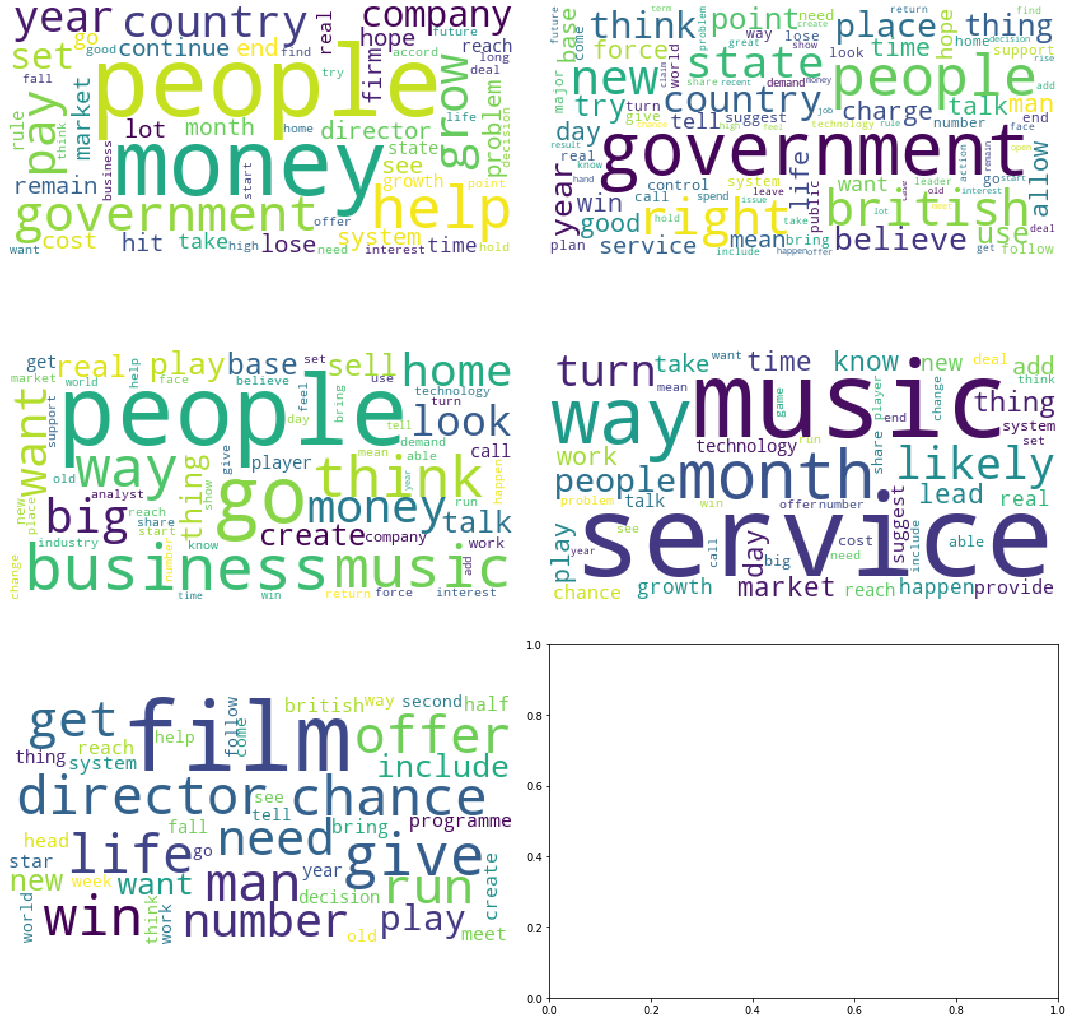

In [168]:
plot_centroids_as_wordclouds(tfidf,clusters,n_cols=2)

### Alternative 2.1 - Use information from all documents

In [52]:
subsample = sort_scores(RESULTS.dict['filtered_docs'], 'norm_tf_idf')
subsample.head()

word   idf  max_tf_idf  avg_tf_idf  norm_tf_idf  centroid_score
69     game 0.635       1.000       1.000        1.000           1.000
80      win 0.383       0.834       0.860        0.807           0.860
19     play 0.488       0.768       0.760        0.751           0.760
143  player 0.710       0.907       0.609        0.687           0.609
84    match 0.985       0.971       0.490        0.614           0.490

3 2
(3, 2)


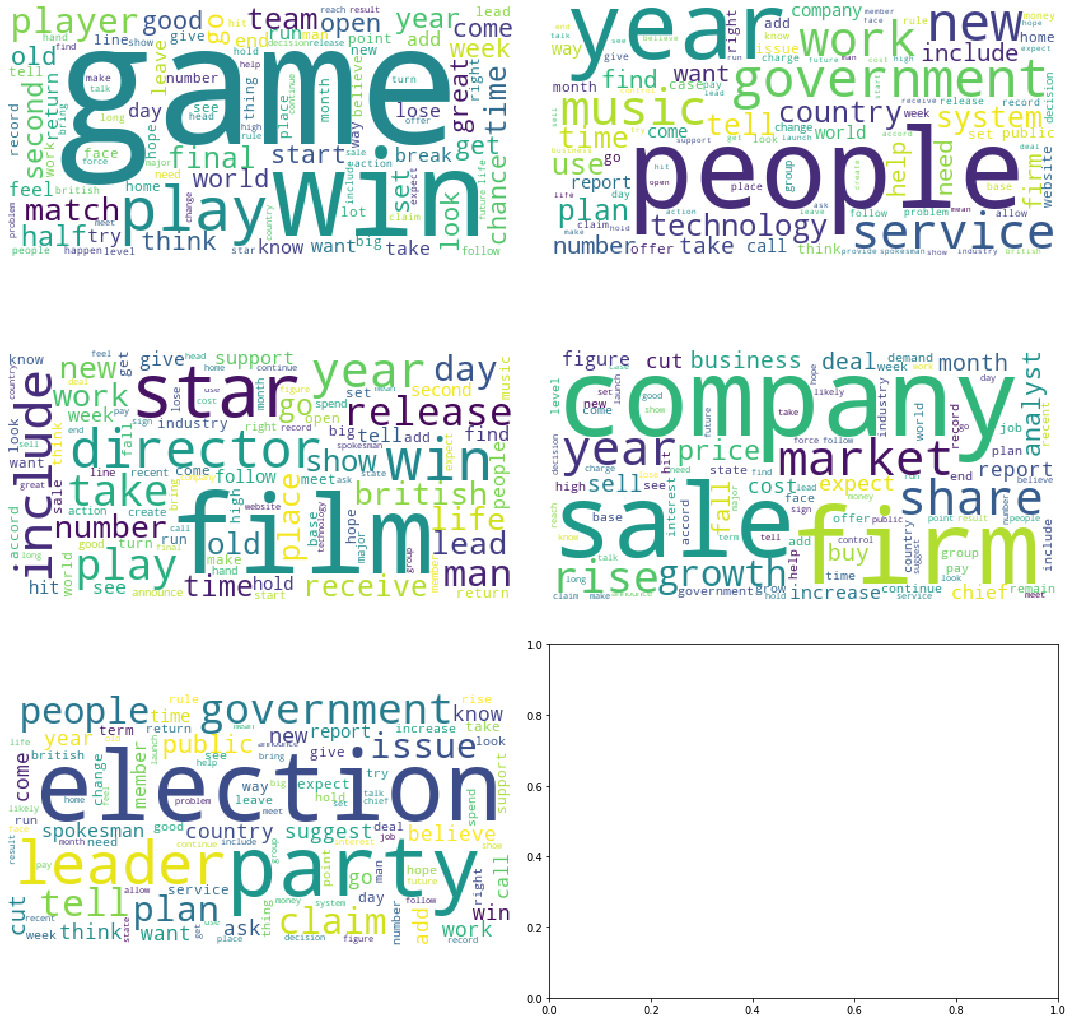

In [54]:
plot_centroids_as_wordclouds(tfidf_cluster_0, clusters,n_cols=2)

### Alternative 2.2 - Use information of the documents of that cluster